# Exploratory Data Analysis for Transformer Explainability

The objective this notebook is to discover and implement explainability techniques for Large Language Models (LLMs). We focus on explaining outputs with respect to input tokens the model ingests. All of the following analyses are done on the [BERT base model (uncased)](https://huggingface.co/bert-base-uncased) for Masked Language Modeling (MLM) but can be applied to any other LLM and task.

## Table of Contents
1. Prerequisites
2. Attention-Based Explainations
3. Gradient-Based Explainations

## 1. Prerequisites

In [4]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.5 MB/s eta 0:00:00


In [5]:
# import required libraries
import numpy as np
import torch
from torch.nn import functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import BertTokenizer, BertForMaskedLM

## Load model and tokenizer

In [75]:
model_name = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name, return_dict=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Generate output

We will use the example input sentence "Paris is the capital of France" where we want our model predict the word 'capital' in the sentence for our analyses. Let's also have it generate its top 10 predictions and their probabilites to see if it is working correctly.

In [38]:
sentence = "Paris is the " + tokenizer.mask_token + " of France"
inputs = tokenizer(sentence, return_tensors="pt") # mask the word "capital"

labels = inputs["input_ids"].clone() # create ground truth label

labels[labels != tokenizer.mask_token_id] = -100 # only calculate loss on masked tokens

outputs = model(**inputs,
                labels=labels,
                output_hidden_states=True,
                output_attentions=True
                )

outputs.loss # output loss

tensor(21.9830, grad_fn=<NllLossBackward0>)

In [14]:
logits = outputs.logits

mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = logits[0, mask_token_index, :]

top_10 = torch.topk(mask_token_logits, 10, dim=1)
top_10_tokens = top_10.indices[0].tolist()
top_10_probs =  F.softmax(top_10.values, dim=-1)[0].tolist()

for token, prob in zip(top_10_tokens, top_10_probs):
   word = tokenizer.decode([token])
   pred_sentence = sentence.replace(tokenizer.mask_token, word)
   print(pred_sentence, f'Score: {prob}')

Paris is the capital of France Score: 0.9982383251190186
Paris is the center of France Score: 0.00041711077210493386
Paris is the city of France Score: 0.000346692482708022
Paris is the heart of France Score: 0.0003087295335717499
Paris is the centre of France Score: 0.0002591701049823314
Paris is the birthplace of France Score: 0.00016504249651916325
Paris is the metropolis of France Score: 0.00010316971747670323
Paris is the capitol of France Score: 5.856313873664476e-05
Paris is the prefecture of France Score: 5.847239663125947e-05
Paris is the capitals of France Score: 4.4775726564694196e-05


In [6]:
# Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
attns = outputs.attentions
num_layers = len(attns)
layer_0 = attns[0]
head_0 = layer_0[:,0].detach().numpy()

print(f'Number of layers in {model_name}: {num_layers}')
print(f'Size of each layer: {layer_0.size()}') # (batch, num_heads, sequence length, sequence_length)
print(f'Shape of each head in layer: {head_0.shape}')

Number of layers in bert-base-uncased: 12
Size of each layer: torch.Size([1, 12, 9, 9])
Shape of each head in layer: (1, 9, 9)


In [64]:
def get_outputs(sentence, labels=None):
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.decode(inputs['input_ids'][0])
    outputs = model(**inputs, labels=labels, output_hidden_states = True, output_attentions=True)
    return tokens, outputs

## 1. Attention-Based Attribution

### Visualize attention weights by layer

In [8]:
def plot_layer_attns(sentence):
    tokens, outputs = get_outputs(sentence)
    attns = outputs.attentions
    ticks = (tokens + ' ' + '[EOS]').split()
    plt.figure(figsize=(9, 9))

    for layer_idx in range(len(attns)):
        layer_attns = attns[layer_idx]
        avg_layer_attns = (layer_attns.sum(axis=1) / layer_attns.size(1))[0].detach().numpy() # average attention weights over all heads in layer
        ax = plt.subplot(4, 3, layer_idx + 1)
        plt.imshow(avg_layer_attns)
        plt.title(f'layer {layer_idx}')
        plt.xticks(range(len(ticks)), ticks, rotation=90);
        plt.yticks(range(len(ticks)), ticks);
        plt.colorbar(label='attention weights')

    plt.suptitle(f'Attention weights by layer')
    plt.tight_layout()
    plt.show()

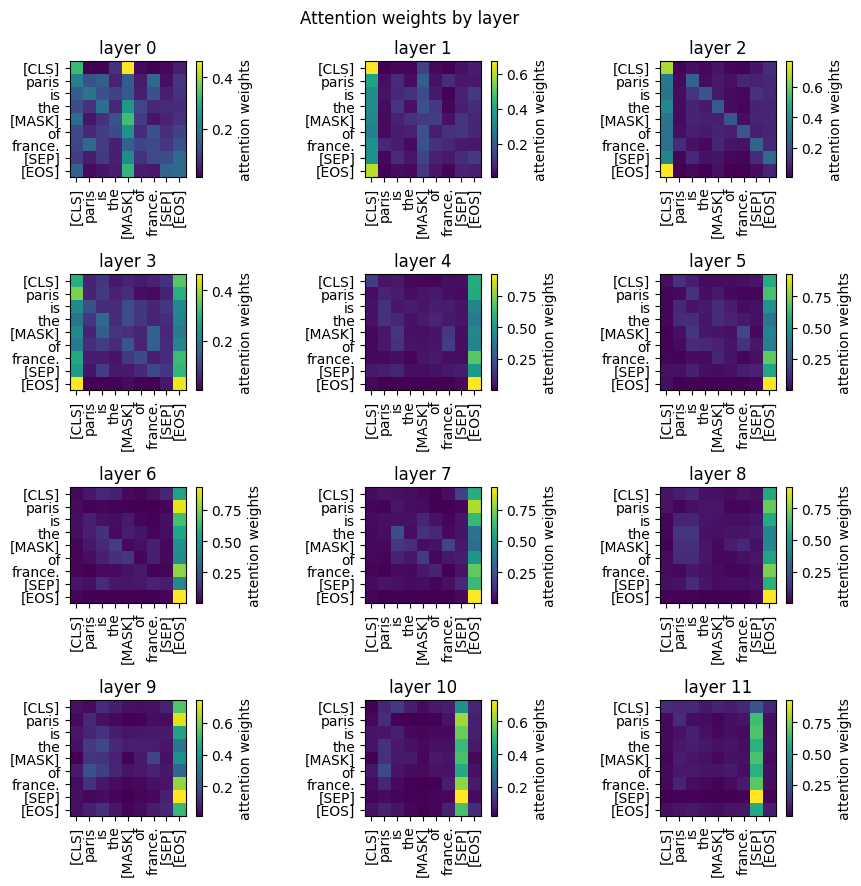

In [9]:
plot_layer_attns(sentence)

## Visualize attention weights by head for a given layer

In [10]:
def plot_attention_heads(sentence, layer_idx):
    tokens, outputs = get_outputs(sentence)
    attns = outputs.attentions
    layer_attns = attns[layer_idx]
    ticks = (tokens + ' ' + '[EOS]').split()
    plt.figure(figsize=(9, 9))

    for head_idx in range(layer_attns.size(1)):
        head_attns = layer_attns[:,head_idx][0].detach().numpy()
        ax = plt.subplot(4, 3, head_idx + 1)
        plt.imshow(head_attns)
        plt.title(f'head {head_idx}')
        plt.xticks(range(len(ticks)), ticks, rotation=90);
        plt.yticks(range(len(ticks)), ticks);
        plt.colorbar(label='attention weights')

    plt.suptitle(f'Attention weights by head in layer {layer_idx}')
    plt.tight_layout()
    plt.show()

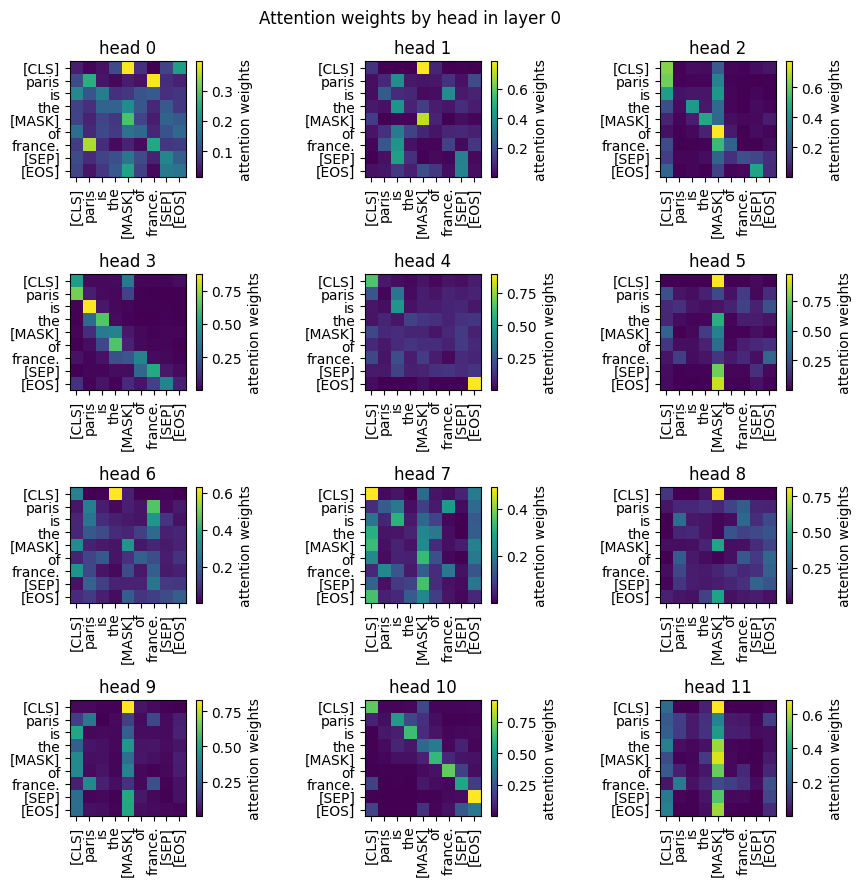

In [11]:
# visualize attention weights for layer 1
plot_attention_heads(sentence, layer_idx=0)

We observe strong attention weights for the special tokens and weak attention weights for every other token. Thus, they are not a good representation of token-to-token attentions. Other researchers have come to a similar conclusion. Attention matrices aren't always a good indicator of finding which tokens are more important or which token is related to which.

### Average max attention weights per layer

In [12]:
def plot_attention_heads(sentence):
    avg_max_attns  = []
    tokens, outputs = get_outputs(sentence)
    attns = outputs.attentions

    for layer_idx in range(len(attns)):
      layer_attns = attns[layer_idx]
      for head_idx in range(layer_attns.size(1)):
        head_attns = layer_attns[:,head_idx][0].detach().numpy()
        avg_max_attn_head = np.mean(np.amax(head_attns, axis=1))
        avg_max_attns.append(avg_max_attn_head)

    avg_max_attns = np.array(avg_max_attns)
    avg_max_attns = avg_max_attns.reshape(12, 12)

    ax = plt.subplot()
    plt.imshow(avg_max_attns)

    plt.title("Average max attention weights")
    plt.xticks(range(12), range(12), rotation=90)

    plt.yticks(range(12), range(12))
    plt.xlabel('heads')
    plt.ylabel('layers')
    plt.colorbar(label='attention weights')
    plt.show()



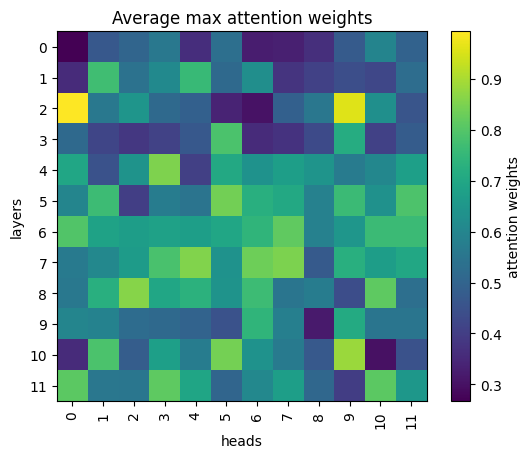

In [13]:
plot_attention_heads(sentence)

## 2. Gradient-Based Explainations

### Visualizing gradients of outputs w.r.t word embeddings

In [20]:
def get_word_grad(model, sentence, labels):
    embedding_layer = model.bert.embeddings.word_embeddings # word_embeddings + position_embeddings + token_embeddings
    embedding_matrix = embedding_layer.weight.requires_grad
    embedding_layer.weight.requires_grad = True

    emb_grads = []

    def grad_hook(module, grad_in, grad_out):
        emb_grads.append(grad_out[0])

    emb_hook = embedding_layer.register_backward_hook(grad_hook)

    model.zero_grad()
    tokens, outputs = get_outputs(sentence, labels)
    loss = outputs.loss
    loss.backward()

    grad = emb_grads[0][0].cpu().numpy() # grad w.r.t to word embeddings
    grad = torch.norm(torch.from_numpy(grad), dim=-1)  # normalize gradient such that we get a scalar value
    grad = grad / torch.max(grad)
    grad = np.array(grad)

    embedding_layer.requires_grad = embedding_matrix
    emb_hook.remove()
    model.eval()

    grad_dict = {"tokens": tokens, "gradient": grad}

    return grad_dict

In [21]:
def plot_gradients(tokens, gradients, title):
  plt.figure(figsize=(21,3))
  xvals = [ x + str(i) for i,x in enumerate(tokens)]
  colors =  [ (0,0,1, c) for c in (gradients) ]

  plt.tick_params(axis='both', which='minor', labelsize=29)
  p = plt.bar(xvals, gradients, color=colors, linewidth=1 )
  plt.title(title)
  p=plt.xticks(ticks=[i for i in range(len(tokens))], labels=tokens, fontsize=12,rotation=90)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


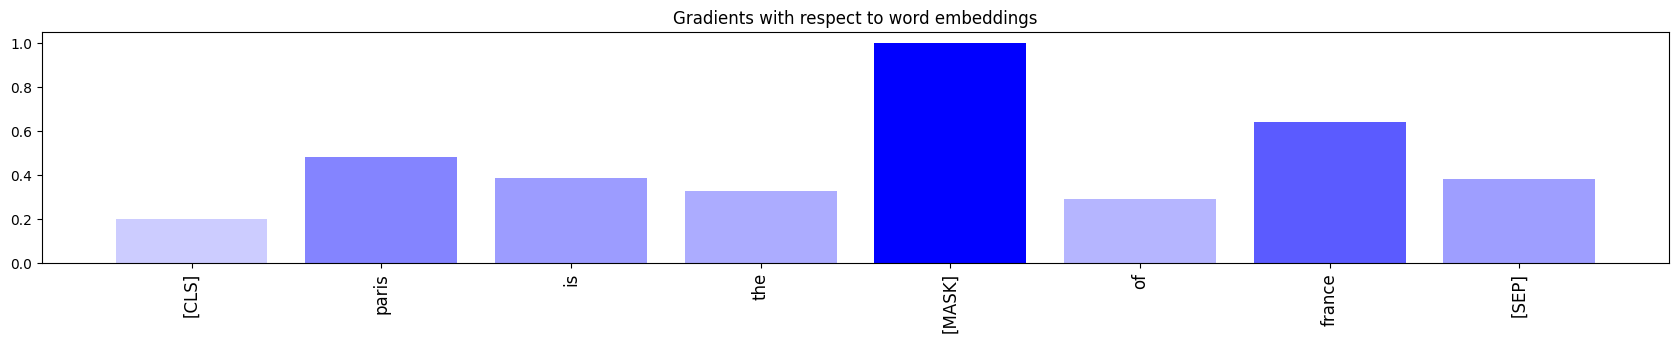

In [23]:
grads = get_word_grad(model, sentence, labels)

plot_gradients(grads['tokens'], grads['gradient'], "Gradients with respect to word embeddings")

Directly calculating the gradients of the output with respect to the input is flawed because it violates the Sensitivity axiom of attribution techniques. The Sensivity axiom states that if there is a change in output given a change in input feature, then that attribution must have a non-zero attribution. However, the gradients of features near the vicinity of the input often times have a gradient a zero.

In [39]:
def toy_model(x):
  output = 1 - max(0, 1 - x)
  return output

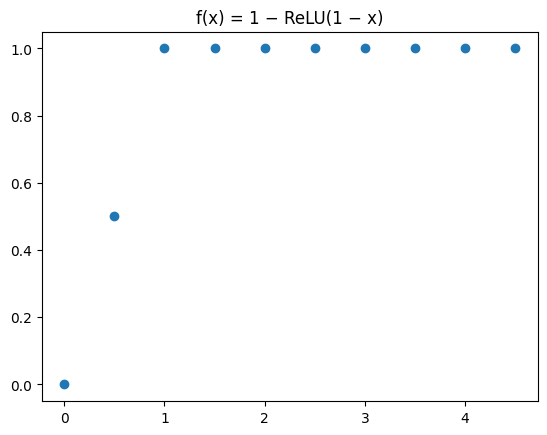

In [40]:
inputs = [x  / 10.0 for x in range(0, 50, 5)]
outputs = [toy_model(x) for x in inputs]

plt.scatter(inputs, outputs)
plt.title('f(x) = 1 − ReLU(1 − x)')
plt.show()

Consider the following toy model function that takes as input a single feature x: f(x) = 1 - ReLU(1-x). At x=0, f(x) is equal to 0 and at x=2, f(x) is equal to 1. Thus, x=2 must have a non-zero attribution. However, the shape of the graph at x=2 is flat and thus, its gradient is 0, causing the attribution at that point to also equal 0. This motivates an improved gradient-based explaination method.

# Integrated gradients

$$IG_i(x) = (x_i - x_i^\prime) \times \int_{\alpha=0}^{1} \frac{dF(\alpha x + (1-\alpha)x^\prime)}{dx}d\alpha$$

where:
$$i = \text{feature} \\
x = \text{input} \\
x^\prime = \text{baseline} \\
\alpha = \text{interpolation constant to perturb features by}$$



In practice, computing a definite integral is not always numerically possible and can be costly so using Riemann's approximation, it can be rewritten as:

$$IG_i(x) = (x_i - x_i^\prime) \times ∑
\frac{dF(x^\prime + \frac{k}{m} \times(x - x^\prime)}{dx} \times \frac{1}{m}$$

where:

$$
i = \text{feature} \\
x = \text{input} \\
x^\prime = \text{baseline} \\
k = \text{scaled feature pertubation constant} \\
m = \text{number of steps in the Riemann sum approximation}
$$

Introduced by [Axiomatic Attribution for Deep Networks](https://arxiv.org/pdf/1703.01365.pdf), integrated gradients satisfies the Sensitivity axiom by comparing the difference in outputs between the input and a baseline. The baseline is an informationless input that results in a neutral prediction. In the case of NLP, it is a zero embedding matrix.

In [82]:
import copy
def calc_integrated_gradients(inputs, baseline, num_steps):
  input_embed = model.bert.embeddings.word_embeddings.weight
  copy_embed = copy.deepcopy(input_embed.data)

  if baseline is None:
    # create baseline
    baseline = torch.zeros_like(copy_embed)

  grads = []

  for step in range(num_steps + 1):
    input_embed.data =  baseline + step/num_steps * (copy_embed - baseline)
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
    logits, hidden_states = outputs.logits, outputs.hidden_states
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    mask_token_logits = logits[0, mask_token_index, :]
    mask_token_logit = torch.argmax(mask_token_logits, dim=-1)

    # calculate the derivates of the output of BertEmbedding
    out_embed = hidden_states[0]
    g = torch.autograd.grad(logits, out_embed, grad_outputs=torch.ones_like(logits))[0]
    grads.append(g)

  # stack grads along first dimension to create a new tensor
  grads = torch.stack(grads)

  # approx integral
  grads = (grads[:-1] + grads[1:]) / 2
  avg_grad = grads.mean(0)

  integrated_grads = out_embed * avg_grad

  return integrated_grads

def calc_scores(integrated_grads):
  scores = torch.sqrt((integrated_grads ** 2).sum(-1))
  max_s, min_s = scores.max(1, True).values, scores.min(1, True).values
  normalized_scores = (scores - min_s) / (max_s - min_s)
  return normalized_scores[0].tolist()

In [83]:
inputs = tokenizer(sentence, return_tensors='pt')
integrated_grads = calc_integrated_gradients(inputs, None, 3)
scores = calc_scores(integrated_grads)
tokens = tokenizer.decode(inputs['input_ids'][0]).split()

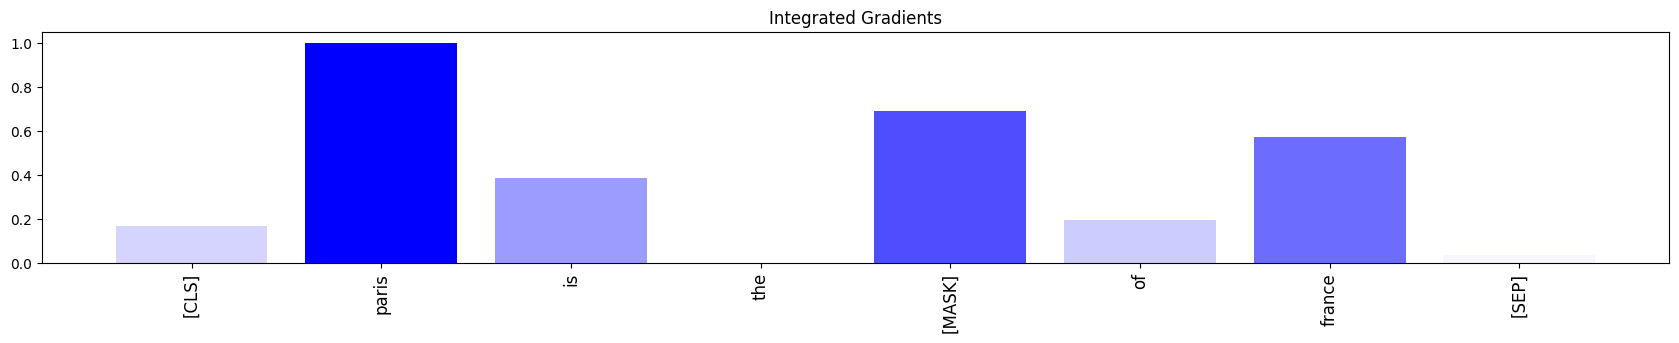

In [88]:
plot_gradients(tokens, scores, title='Integrated Gradients')